## Simulator Feature Wishlist:
 * Have the recommender weight unwatched videos higher + have users more willing to watch new videos
 * Give each user a baseline rating: to emulate how some users rate higher than others
 * (WIP) Implement different user behaviors in response to recommendations

## Potential Things to Look Into:
 * Should film genres also be percentages instead of binary is or is not values? Some videos are definitely more of one genre than another, so assigning them binary values removes that information from the simulator
 * Perhaps have a more in-depth matrix of metadata for videos (e.g. vectors indicating authors / directors, run time, etc.)? This could potentially allow for more realistic viewing / recommendation schemes and also allow for more complex user simulated behaviors

In [47]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import pandas as pd[]
import numpy as np
import random
from scipy.sparse.linalg import svds
from IPython.display import display

## Setup

We have two types of movies, type 1 and type 2. Each movie has a vector assciotated with them, [x,y]. x and y are binary variables with possible values of 0 and 1. x = 1 means that the film is of type 1, and y = 1 means that the film is of type2.
Each user also has a hidden vector associated with him or her, [b,c], where b and c are preferences for type 1 and type 2 films respectively. $0 \leq b,c \leq 1$ and $b + c = 1$. If a user's perference for a type of film is [a,b], then this user has $a$ chance of accepting recommendations of films of type 1 and $b$ chance of accepting recommendations of films of type 2. This user will rate a film of type 1: $a*5 $

In [48]:
# Total number of film genres and maximum number
# of genres a single film may belong to
NUM_GENRES = 2
MAX_FILM_GENRES = 2

# Maximum film rating (e.g. 5 uses the rating scale 0-5)
MAX_RATING = 5

# Higher values = stronger user genre preferences
# Use higher values with higher NUM_GENRES values
# Reasonable values are probably b/w 0.1 and 10
USER_POLARIZATION_STRENGTH = 1
FILM_POLARIZATION_STRENGTH = 1

# A user's "behavior" determines how a user chooses
# which video(s) to watch at each simulation step
# NAMES is a one-word description of each behavior,
# and DISTRIBUTION determines the ratio of behaviors
# among the created users
BEHAVIOR_PROP_IDX = NUM_GENRES
BEHAVIOR_NAMES = ['follower', 'stubborn', 'mixed']
BEHAVIOR_DISTRIBUTION = [1, 1, 1]

# If False, all users only consider recommended
# videos when deciding what to watch next
USE_BEHAVIOR = True

# A film's "quality" determines the mean rating
# of the film, and is used as the baseline which
# user preferences modify to get the final rating
QUALITY_PROP_IDX = NUM_GENRES
QUALITY_MIN = MAX_RATING / 4.0
QUALITY_MAX = 3 * MAX_RATING / 4.0

# If False, the average film rating is used as the
# baseline when calculating new ratings instead
USE_QUALITY = True

# Validate and standardize the behavior configuration parameters
if len(BEHAVIOR_NAMES) != len(BEHAVIOR_DISTRIBUTION):
    raise ValueError("BEHAVIOR_NAMES and BEHAVIOR_DISTRIBUTION "
            "must have the same length.")
BEHAVIOR_NAMES = np.array(BEHAVIOR_NAMES)
BEHAVIOR_DISTRIBUTION = np.array(BEHAVIOR_DISTRIBUTION) / float(sum(BEHAVIOR_DISTRIBUTION))

In [49]:
def generate_users(number_of_users):
    """
    Generate a user matrix, where each row of the
    matrix stores the properties of a user:
    [genre1_preference, ..., genreN_preference, behavior]
    
    The genre preferences of each user sum to 1.
    behavior will be an integer b/w 0 and num_behaviors
    """
    results = []
    for i in range(number_of_users):
        user_prefs = np.random.dirichlet(
                np.ones(NUM_GENRES)/USER_POLARIZATION_STRENGTH, size=1)[0]
        behavior = np.random.choice(np.arange(len(BEHAVIOR_NAMES)),
                p=BEHAVIOR_DISTRIBUTION)
        user_props = np.append(user_prefs, behavior)
        results.append(user_props)
    return np.array(results)

def generate_films(number_of_films):
    """
    Generate a film matrix, where each row of the
    matrix represents the properties of a film:
    [is_genre1, ..., is_genreN, quality]
    
    The is_genre values will either be 0 or 1.
    quality will be b/w QUALITY_MIN and QUALITY_MAX.
    """
    results = []
    for i in range(number_of_films):
        film_genres = np.random.dirichlet(
                np.ones(NUM_GENRES)/FILM_POLARIZATION_STRENGTH, size=1)[0]
        quality = random.uniform(QUALITY_MIN, QUALITY_MAX)
        film_props = np.append(film_genres, quality)
        results.append(film_props)
    return np.array(results)

In [50]:
NUM_USERS = 6040 # 6040
NUM_FILMS = 3883 # 3883

users = generate_users(NUM_USERS)
films = generate_films(NUM_FILMS)

display(users)
print(users.shape)
display(films)
print(films.shape)

array([[0.52779085, 0.47220915, 1.        ],
       [0.77602264, 0.22397736, 1.        ],
       [0.48194495, 0.51805505, 2.        ],
       ...,
       [0.8896618 , 0.1103382 , 1.        ],
       [0.73047352, 0.26952648, 2.        ],
       [0.1219017 , 0.8780983 , 0.        ]])

(6040, 3)


array([[0.0706062 , 0.9293938 , 3.72434006],
       [0.80912847, 0.19087153, 1.85035549],
       [0.10658992, 0.89341008, 2.50485788],
       ...,
       [0.51892595, 0.48107405, 1.31604644],
       [0.68307538, 0.31692462, 3.58830438],
       [0.54894733, 0.45105267, 3.74739987]])

(3883, 3)


In [51]:
def get_user_film_compatibility(userID, filmID):
    """
    Returns a value between 0 and 1 indicating how much
    a user's preferences aligns with the film's genre(s).
    """
    user_prefs = users[userID][:NUM_GENRES]
    film_genres = films[filmID][:NUM_GENRES]
    return np.sum(user_prefs * film_genres)

# Compute the compatabilities of a random sample of users
# and films, so some stats can be calcuated on them
compats = []
sample_userIDs = random.sample(np.arange(NUM_USERS), min(500, NUM_USERS))
sample_filmIDs = random.sample(np.arange(NUM_FILMS), min(500, NUM_FILMS))
for userID in sample_userIDs:
    for filmID in sample_filmIDs:
        compats.append(get_user_film_compatibility(userID, filmID))

mean_compatibility = 1.0 * sum(compats) / len(compats)
max_abs_compatibility = max(max(compats), abs(min(compats)))

print("Mean compatibility: %f" % mean_compatibility)
print("Max absolute compatibility: %f" % max_abs_compatibility)

Mean compatibility: 0.499988
Max absolute compatibility: 0.994946


In [52]:
# Determines how much a user's compatibility with 
# the film affects the final rating. The final
# rating given will be mean_film_rating + x,
# where -CRS <= x <= CRS
COMPATIBILITY_RATING_STRENGTH = 3

def get_user_film_rating(userID, filmID, actual_ratings=None, is_initial_rating=False):
    """
    Returns a value between 0 and MAX_RATING indicating the
    rating the user would give the film upon watching it.
    
    actual_ratings must be provided when USE_QUALITY and
    is_initial_rating is False, so the current mean rating
    of the film can be calculated.
    
    is_initial_rating should be set True when generating the
    starting ratings for the film.
    """
    compatibility = get_user_film_compatibility(userID, filmID)
    
    if USE_QUALITY:
        base_rating = films[filmID][QUALITY_PROP_IDX]
    else:
        if is_initial_rating:
            return round(MAX_RATING * compatibility)
        else:
            film_ratings = actual_ratings[:, filmID]
            base_rating = np.mean(film_ratings[film_ratings.nonzero()])

    # Convert compatibility to a value within [-CRS, +CRS]
    compat_influence = ((compatibility - mean_compatibility)
            / max_abs_compatibility) * COMPATIBILITY_RATING_STRENGTH
    return max(min(round(base_rating + compat_influence), MAX_RATING), 0)

def generate_initial_ratings(users, films, view_rate, rescale_to_midline=False):
    """
    Generates a (num_films, num_users) rating matrix, where
    each row represents the ratings that film has received
    from all users.
    
    view_rate is the chance a user will view a given film.
    
    If rescale_to_midline is True, the ratings are scaled
    such that mean of non-zero ratings is MAX_RATING / 2.
    """
    results = []
    for filmID in range(films.shape[0]):
        film_ratings = []
        for userID in range(users.shape[0]):
            ran = random.uniform(0,1)
            if (ran <= view_rate):
                rating = get_user_film_rating(userID, filmID, is_initial_rating=True)
                film_ratings.append(rating)
            else:
                film_ratings.append(0)
        results.append(film_ratings)
    results = np.array(results)
    # Perform rescaling if necessary
    if rescale_to_midline:
        results = results * ((MAX_RATING / 2.0) / (results[results.nonzero()].mean()))
        results = np.clip(np.round(results), 0, MAX_RATING)
    return results

In [53]:
INITIAL_VIEWING_RATE = 0.05 # 0.05
RESCALE_TO_MIDLINE = True

initial_ratings = generate_initial_ratings(users, films,
        INITIAL_VIEWING_RATE, rescale_to_midline=RESCALE_TO_MIDLINE)

display(initial_ratings)
print(initial_ratings.shape)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 3., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

(3883, 6040)


In [54]:
# The number of singular values to compute with SVD
# Larger values give more accurate predictions, but
# take longer to compute (and give longer simulator
# convergence times)
# Reasonable values are probably b/w 10 and 50
K_VAL = 50

def get_predicted_ratings(actual_ratings):
    """
    Returns a (num_users, num_films) matrix containing
    the predicted ratings each user would each film.
    """
    # Only consider non-zero ratings when calculating the mean
    masked_user_ratings = np.ma.masked_equal(initial_ratings.T, 0)
    user_ratings_mean = masked_user_ratings.mean(axis=1).data
    # Calculate SVD values of demeaned ratings + estimate new ratings
    R_demeaned = actual_ratings.T - user_ratings_mean.reshape(-1, 1)
    U, sigma, Vt = svds(R_demeaned, k=K_VAL)
    sigma = np.diag(sigma)
    predicted_ratings = np.round(np.dot(np.dot(U, sigma), Vt) +
            user_ratings_mean.reshape(-1, 1))
    return predicted_ratings

example_predictions = get_predicted_ratings(initial_ratings)
display(example_predictions)
print(example_predictions.shape)

array([[ 0.,  0.,  0., ...,  0., -0., -0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 1.,  0.,  0., ...,  0.,  0., -0.],
       [-0.,  0.,  0., ...,  0., -0.,  0.],
       [-0.,  0.,  0., ...,  0.,  0., -0.]])

(6040, 3883)


In [55]:
FOLLOWERS, = list(np.where(users[:, users.shape[1]-1] == 0))

polarity = 0
for userIdx in range(len(FOLLOWERS)):
    example_recs = get_recommendations(example_predictions, FOLLOWERS[userIdx])
    if example_recs[1] != [2, 2]:
        polarity += 1

STUBBORN, = list(np.where(users[:, users.shape[1]-1] == 1))

polarity = 0
for userIdx in range(len(STUBBORN)):
    example_recs = get_recommendations(example_predictions, STUBBORN[userIdx])
    if example_recs[1] != [2, 2]:
        polarity += 1
        
MIXED, = list(np.where(users[:, users.shape[1]-1] == 2))

polarity = 0
for userIdx in range(len(MIXED)):
    example_recs = get_recommendations(example_predictions, MIXED[userIdx])
    if example_recs[1] != [2, 2]:
        polarity += 1

print(polarity / len(FOLLOWERS))
print(polarity / len(STUBBORN))
print(polarity / len(MIXED))

0.493326488706
0.457183634634
0.482914572864


In [56]:
NUM_RECS = 5

def get_recommendations(predicted_ratings, userID, num_recommendations=NUM_RECS):
    """
    Gets the top num_recommendations film recommendations for
    the provided user, using the rating prediction matrix, and
    returns a tuple containing the recommended film IDs, and
    counts of the recommendations received of each film genre.
    """
    predicted_user_ratings = predicted_ratings[userID]
    recommended_filmIDs = np.argsort(predicted_user_ratings)\
            [-num_recommendations:].tolist()
    film_recs = films[recommended_filmIDs, :]
    genre_counts = [int(sum(film_recs[:, genre_idx]))
            for genre_idx in range(NUM_GENRES)]
    return (recommended_filmIDs, genre_counts)

example_recs = get_recommendations(example_predictions, 0)
print("Example Film Recommendations: " + str(example_recs[0]))
print("Example Distribution: " + str(example_recs[1]))

Example Film Recommendations: [810, 3698, 2089, 221, 2877]
Example Distribution: [2, 2]


## Run the Simulation:

In [57]:
initial_predictions = get_predicted_ratings(initial_ratings)

# A (num_users, num_genres) matrix where each row
# is the number of recommendations that user has
# received of each film genre
initial_distribution_matrix = []

# Get the initial recommendation genre distribution
for userID in range(users.shape[0]):
    (recommended_filmIDs, type_counts) = get_recommendations(initial_predictions, userID)
    initial_distribution_matrix.append(type_counts)

display(initial_distribution_matrix[:10])

[[2, 2],
 [2, 2],
 [0, 4],
 [2, 2],
 [2, 2],
 [2, 2],
 [2, 2],
 [3, 1],
 [2, 2],
 [2, 2]]

In [58]:
def step_simulation(actual_ratings, predicted_ratings,
                    rec_genre_counts, verbose=False):
    """
    Runs one step of the simulation:
    
    Gives new recommendations to each user, and simulates them
    viewing + rating a random selection of them.
    
    Returns the new rating matrix, the new distribution matrix of
    recommended film genres, and the # of changes in this matrix.
    
    If verbose is True, prints extra debugging information.
    """
    new_ratings = actual_ratings.copy()
    new_distribution_matrix = []
    num_distribution_changes = 0
    
    for userID in range(users.shape[0]):
        user = users[userID]
        (recommended_filmIDs, new_genre_counts) = \
                get_recommendations(predicted_ratings, userID)
        new_distribution_matrix.append(new_genre_counts)
        
        # Check for changes in the user's recommendation distribution
        if (new_genre_counts[0] != rec_genre_counts[userID][0]) or \
                (new_genre_counts[1] != rec_genre_counts[userID][1]):
            num_distribution_changes += 1
        
        # Determine whether the user will watch each
        # recommended film, and assign a rating if so
        for filmID in recommended_filmIDs:
            compatibility = get_user_film_compatibility(userID, filmID)
            ran = random.uniform(0,1)
            if ran <= compatibility:
                rating = get_user_film_rating(userID, filmID, actual_ratings)
                new_ratings[filmID, userID] = rating

    return (new_ratings, new_distribution_matrix, num_distribution_changes)

In [59]:
MAX_STEPS = 500
CHANGE_THRESHOLD = 0
VERBOSE = False

ratings = initial_ratings.copy()
predictions = initial_predictions.copy()
rec_distribution = list(initial_distribution_matrix)
num_changes_over_time = []

for step in range(MAX_STEPS):
    predictions = get_predicted_ratings(ratings)
    ratings, rec_distribution, num_changes = step_simulation(ratings,
            predictions, rec_distribution, verbose=VERBOSE)
    num_changes_over_time.append(num_changes)
    if step > 0 and num_changes <= CHANGE_THRESHOLD:
        print("Convergence!")
        break
    print("Step #%d: Num Changes = %d" % (step, num_changes))

Step #0: Num Changes = 0
Step #1: Num Changes = 3209
Step #2: Num Changes = 2824
Step #3: Num Changes = 2425
Step #4: Num Changes = 1958
Step #5: Num Changes = 1697
Step #6: Num Changes = 1514
Step #7: Num Changes = 1390
Step #8: Num Changes = 1281
Step #9: Num Changes = 1247
Step #10: Num Changes = 1214
Step #11: Num Changes = 1184
Step #12: Num Changes = 1140
Step #13: Num Changes = 1072
Step #14: Num Changes = 1016
Step #15: Num Changes = 1012
Step #16: Num Changes = 925
Step #17: Num Changes = 900
Step #18: Num Changes = 869
Step #19: Num Changes = 760
Step #20: Num Changes = 811
Step #21: Num Changes = 731
Step #22: Num Changes = 692
Step #23: Num Changes = 655
Step #24: Num Changes = 632
Step #25: Num Changes = 622
Step #26: Num Changes = 656
Step #27: Num Changes = 566
Step #28: Num Changes = 541
Step #29: Num Changes = 509
Step #30: Num Changes = 516
Step #31: Num Changes = 488
Step #32: Num Changes = 474
Step #33: Num Changes = 457
Step #34: Num Changes = 452
Step #35: Num Cha

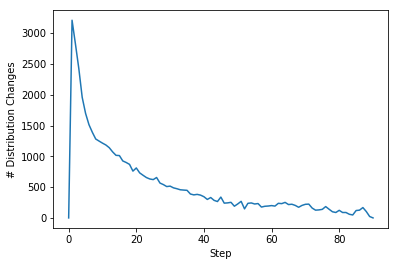

In [60]:
# Plot the recommendation distribution changes over time
plt.plot(num_changes_over_time)
plt.xlabel("Step")
plt.ylabel("# Distribution Changes")
plt.show()

### Observations:
Note that the higher the `COMPATIBILITY_RATING_STRENGTH`, the greater the difference between the average rating and the film quality, as expected. In general, the average rating should be higher than the film quality, because films will be recommended to users that the algorithm predicts will like it. An average rating that is lower the film quality suggests that the recommender made poor decisions when recommending that film to users.

Also note that higher quality films have more ratings, as they are recommended to more people.

In [61]:
def display_ratings_stats(filmID):
    film_quality = films[filmID][QUALITY_PROP_IDX]
    film_ratings = ratings[filmID]
    film_ratings = film_ratings[film_ratings.nonzero()]
    print("Film Matrix: " + str(films[filmID]))
    print("Film Quality: " + str(film_quality))
    print("Average Rating: " + str(film_ratings.mean()))
    display(film_ratings)

# Print some stats about the film ratings
mean_ratings = np.true_divide(ratings.sum(1),(ratings!=0).sum(1))
print("Sample Film\n-----------\n")
display_ratings_stats(0)
print("\n\nHighest Rated Film\n------------------\n")
display_ratings_stats(np.argmax(mean_ratings))
print("\nLowest Rated Film\n-----------------\n")
display_ratings_stats(np.argmin(mean_ratings))

Sample Film
-----------

Film Matrix: [0.0706062  0.9293938  3.72434006]
Film Quality: 3.7243400599936947
Average Rating: 4.044615384615384


array([4., 4., 5., ..., 4., 3., 3.])



Highest Rated Film
------------------

Film Matrix: [0.99487933 0.00512067 3.7477582 ]
Film Quality: 3.747758203168559
Average Rating: 4.089123867069486


array([4., 4., 4., 4., 4., 3., 5., 3., 4., 5., 2., 5., 5., 3., 4., 5., 2.,
       4., 5., 4., 4., 4., 4., 5., 3., 3., 4., 4., 5., 3., 3., 4., 4., 5.,
       2., 4., 3., 4., 5., 5., 3., 3., 5., 5., 5., 5., 5., 4., 5., 5., 4.,
       5., 4., 3., 4., 5., 3., 5., 4., 5., 5., 5., 4., 4., 5., 4., 2., 5.,
       4., 2., 5., 5., 4., 4., 5., 4., 4., 5., 2., 3., 5., 3., 4., 3., 3.,
       3., 3., 2., 5., 5., 5., 4., 5., 4., 5., 4., 4., 3., 4., 5., 3., 5.,
       4., 5., 4., 4., 4., 5., 5., 4., 4., 5., 4., 5., 5., 3., 4., 3., 2.,
       5., 2., 4., 5., 3., 4., 5., 4., 5., 4., 5., 3., 5., 4., 5., 4., 5.,
       4., 4., 3., 5., 5., 4., 4., 2., 5., 2., 5., 4., 5., 5., 3., 4., 3.,
       5., 3., 5., 3., 5., 2., 3., 3., 4., 3., 3., 5., 4., 5., 2., 5., 5.,
       4., 5., 4., 4., 5., 4., 5., 5., 4., 4., 5., 5., 4., 4., 3., 3., 4.,
       4., 2., 4., 4., 5., 5., 4., 5., 5., 4., 5., 4., 5., 5., 3., 3., 4.,
       5., 5., 5., 4., 4., 4., 5., 5., 5., 4., 3., 5., 2., 5., 4., 4., 3.,
       2., 4., 5., 5., 5.


Lowest Rated Film
-----------------

Film Matrix: [0.48818884 0.51181116 1.40722948]
Film Quality: 1.407229483547254
Average Rating: 1.0


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [62]:
sorted_movies = np.argsort(-mean_ratings)

for i in range(10):
    display_ratings_stats(sorted_movies[i])

Film Matrix: [0.99487933 0.00512067 3.7477582 ]
Film Quality: 3.747758203168559
Average Rating: 4.089123867069486


array([4., 4., 4., 4., 4., 3., 5., 3., 4., 5., 2., 5., 5., 3., 4., 5., 2.,
       4., 5., 4., 4., 4., 4., 5., 3., 3., 4., 4., 5., 3., 3., 4., 4., 5.,
       2., 4., 3., 4., 5., 5., 3., 3., 5., 5., 5., 5., 5., 4., 5., 5., 4.,
       5., 4., 3., 4., 5., 3., 5., 4., 5., 5., 5., 4., 4., 5., 4., 2., 5.,
       4., 2., 5., 5., 4., 4., 5., 4., 4., 5., 2., 3., 5., 3., 4., 3., 3.,
       3., 3., 2., 5., 5., 5., 4., 5., 4., 5., 4., 4., 3., 4., 5., 3., 5.,
       4., 5., 4., 4., 4., 5., 5., 4., 4., 5., 4., 5., 5., 3., 4., 3., 2.,
       5., 2., 4., 5., 3., 4., 5., 4., 5., 4., 5., 3., 5., 4., 5., 4., 5.,
       4., 4., 3., 5., 5., 4., 4., 2., 5., 2., 5., 4., 5., 5., 3., 4., 3.,
       5., 3., 5., 3., 5., 2., 3., 3., 4., 3., 3., 5., 4., 5., 2., 5., 5.,
       4., 5., 4., 4., 5., 4., 5., 5., 4., 4., 5., 5., 4., 4., 3., 3., 4.,
       4., 2., 4., 4., 5., 5., 4., 5., 5., 4., 5., 4., 5., 5., 3., 3., 4.,
       5., 5., 5., 4., 4., 4., 5., 5., 5., 4., 3., 5., 2., 5., 4., 4., 3.,
       2., 4., 5., 5., 5.

Film Matrix: [0.98463803 0.01536197 3.71076726]
Film Quality: 3.7107672604769433
Average Rating: 4.072829131652661


array([5., 3., 4., 4., 4., 3., 4., 4., 3., 5., 5., 4., 5., 5., 4., 4., 5.,
       4., 4., 3., 5., 5., 3., 4., 2., 3., 5., 4., 5., 2., 4., 3., 3., 5.,
       4., 2., 5., 5., 4., 2., 5., 3., 4., 4., 3., 3., 3., 5., 5., 4., 5.,
       5., 5., 4., 5., 3., 5., 5., 5., 4., 4., 5., 5., 5., 3., 5., 4., 4.,
       5., 5., 3., 5., 4., 3., 5., 5., 4., 3., 3., 5., 4., 5., 5., 5., 3.,
       5., 5., 4., 5., 5., 5., 5., 3., 5., 5., 4., 5., 4., 4., 3., 5., 3.,
       4., 4., 3., 4., 3., 5., 5., 3., 4., 5., 4., 4., 5., 3., 4., 4., 4.,
       4., 5., 4., 3., 5., 4., 3., 5., 4., 4., 5., 3., 4., 3., 4., 3., 3.,
       4., 4., 5., 4., 4., 2., 3., 4., 4., 4., 5., 2., 3., 3., 3., 4., 5.,
       4., 4., 4., 5., 4., 4., 5., 4., 4., 3., 5., 4., 4., 5., 5., 5., 5.,
       5., 3., 4., 4., 3., 4., 4., 4., 5., 5., 4., 4., 3., 5., 5., 4., 3.,
       5., 4., 2., 5., 4., 3., 4., 3., 5., 5., 2., 4., 3., 4., 4., 4., 5.,
       4., 5., 4., 4., 5., 4., 4., 3., 5., 4., 4., 4., 3., 4., 3., 3., 4.,
       4., 3., 3., 3., 3.

Film Matrix: [0.0706062  0.9293938  3.72434006]
Film Quality: 3.7243400599936947
Average Rating: 4.044615384615384


array([4., 4., 5., ..., 4., 3., 3.])

Film Matrix: [0.92556526 0.07443474 3.73284436]
Film Quality: 3.7328443637797797
Average Rating: 4.0108303249097474


array([4., 3., 3., 5., 4., 4., 5., 5., 5., 3., 4., 5., 4., 4., 3., 4., 4.,
       4., 2., 4., 5., 5., 3., 4., 3., 4., 4., 3., 3., 5., 3., 4., 5., 3.,
       3., 5., 3., 5., 5., 4., 3., 4., 4., 4., 3., 5., 4., 4., 3., 5., 5.,
       4., 5., 4., 5., 4., 5., 4., 5., 4., 4., 3., 3., 4., 5., 3., 4., 3.,
       4., 5., 4., 3., 3., 4., 4., 4., 5., 5., 3., 3., 4., 4., 3., 5., 4.,
       5., 5., 3., 5., 4., 4., 3., 4., 3., 4., 4., 5., 4., 4., 5., 3., 5.,
       4., 5., 3., 3., 4., 5., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 5.,
       4., 5., 3., 4., 4., 4., 4., 4., 5., 3., 4., 5., 4., 5., 2., 4., 5.,
       3., 5., 3., 3., 3., 5., 4., 4., 3., 4., 4., 4., 5., 4., 5., 4., 5.,
       4., 5., 4., 4., 2., 5., 4., 5., 4., 5., 5., 4., 3., 4., 4., 5., 5.,
       4., 5., 3., 5., 5., 3., 4., 5., 4., 4., 4., 4., 4., 5., 4., 5., 5.,
       5., 3., 3., 4., 4., 4., 4., 4., 3., 3., 3., 4., 5., 5., 4., 5., 4.,
       5., 5., 4., 4., 4., 5., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 3.,
       3., 5., 5., 4., 3.

Film Matrix: [0.88786649 0.11213351 3.68673335]
Film Quality: 3.686733350909594
Average Rating: 4.00709219858156


array([4., 3., 4., 4., 5., 4., 3., 5., 4., 4., 4., 3., 3., 4., 4., 5., 4.,
       5., 5., 4., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 3., 4., 4.,
       4., 5., 3., 5., 5., 3., 5., 4., 4., 5., 5., 4., 3., 4., 3., 4., 3.,
       4., 3., 3., 5., 4., 3., 4., 4., 4., 4., 4., 5., 4., 5., 3., 4., 4.,
       3., 4., 5., 5., 3., 4., 4., 3., 4., 5., 5., 4., 3., 4., 4., 4., 5.,
       5., 5., 4., 4., 4., 3., 3., 3., 5., 5., 4., 5., 3., 3., 4., 5., 3.,
       5., 5., 3., 4., 4., 3., 5., 5., 3., 3., 4., 3., 4., 3., 5., 3., 4.,
       4., 4., 4., 4., 4., 5., 5., 4., 4., 4., 4., 5., 4., 4., 3., 4., 4.,
       3., 4., 5., 3., 4., 4., 4., 4., 4., 5., 3., 4., 4., 4., 5., 3., 4.,
       3., 4., 4., 4., 3., 4., 5., 4., 5., 4., 4., 5., 3., 5., 4., 5., 3.,
       4., 5., 5., 4., 3., 5., 5., 4., 5., 3., 3., 3., 5., 5., 5., 4., 3.,
       4., 5., 4., 4., 4., 4., 3., 3., 3., 4., 3., 4., 4., 4., 4., 4., 4.,
       4., 3., 4., 4., 3., 4., 4., 4., 4., 5., 4., 4., 4., 3., 5., 4., 4.,
       4., 5., 4., 5., 4.

Film Matrix: [0.99268376 0.00731624 3.67608766]
Film Quality: 3.676087659919463
Average Rating: 4.007022471910112


array([4., 4., 4., 4., 4., 3., 5., 5., 2., 4., 4., 4., 3., 3., 3., 4., 5.,
       5., 3., 5., 4., 5., 4., 2., 5., 2., 3., 4., 5., 2., 5., 2., 5., 3.,
       4., 4., 3., 4., 4., 3., 4., 5., 3., 5., 4., 4., 3., 3., 5., 4., 3.,
       5., 5., 2., 4., 3., 4., 4., 4., 4., 5., 4., 4., 4., 4., 5., 4., 4.,
       3., 5., 5., 3., 5., 5., 5., 3., 5., 5., 5., 4., 5., 3., 2., 3., 2.,
       5., 4., 4., 5., 5., 4., 4., 4., 5., 4., 4., 5., 3., 4., 4., 3., 5.,
       4., 4., 3., 4., 4., 4., 5., 5., 4., 5., 3., 3., 3., 5., 4., 4., 3.,
       3., 3., 5., 3., 4., 4., 4., 4., 3., 5., 2., 5., 3., 5., 2., 3., 5.,
       4., 3., 5., 3., 5., 3., 4., 5., 4., 4., 5., 4., 3., 5., 4., 3., 2.,
       4., 5., 5., 5., 5., 4., 4., 3., 3., 5., 3., 4., 4., 2., 4., 4., 5.,
       4., 4., 5., 5., 3., 5., 3., 3., 4., 3., 5., 3., 5., 4., 3., 3., 3.,
       4., 4., 5., 4., 5., 3., 5., 3., 3., 3., 5., 5., 2., 2., 3., 5., 4.,
       3., 4., 3., 5., 4., 4., 4., 5., 3., 5., 4., 4., 3., 2., 5., 4., 4.,
       5., 5., 5., 4., 5.

Film Matrix: [0.91824805 0.08175195 3.74747372]
Film Quality: 3.7474737205565525
Average Rating: 4.005119453924915


array([3., 3., 4., 3., 4., 4., 4., 3., 5., 3., 5., 5., 4., 4., 4., 4., 4.,
       3., 4., 4., 5., 3., 4., 3., 3., 4., 3., 3., 4., 5., 5., 4., 4., 4.,
       5., 4., 4., 5., 4., 3., 4., 5., 4., 3., 5., 3., 5., 4., 3., 3., 4.,
       3., 5., 5., 4., 4., 4., 3., 3., 4., 5., 4., 3., 5., 5., 4., 4., 4.,
       3., 5., 5., 4., 5., 5., 5., 4., 3., 4., 4., 5., 3., 4., 3., 5., 3.,
       3., 5., 4., 3., 5., 3., 5., 3., 5., 4., 3., 5., 4., 3., 3., 4., 3.,
       4., 4., 4., 3., 5., 5., 4., 3., 4., 5., 4., 4., 5., 4., 5., 5., 4.,
       5., 4., 5., 3., 4., 5., 4., 4., 3., 4., 3., 3., 3., 3., 4., 5., 4.,
       4., 4., 5., 4., 5., 5., 5., 3., 3., 4., 4., 4., 4., 3., 3., 4., 3.,
       5., 3., 5., 3., 4., 5., 4., 3., 5., 3., 4., 4., 5., 4., 5., 5., 5.,
       5., 3., 4., 3., 5., 4., 5., 5., 4., 4., 4., 4., 4., 3., 4., 5., 5.,
       4., 5., 5., 5., 4., 4., 4., 4., 3., 5., 4., 3., 4., 3., 5., 4., 4.,
       5., 3., 3., 5., 5., 4., 5., 5., 4., 4., 3., 4., 5., 4., 5., 3., 5.,
       3., 5., 3., 4., 5.

Film Matrix: [0.9349374  0.0650626  3.73321869]
Film Quality: 3.733218686401059
Average Rating: 4.003898635477583


array([4., 4., 4., 4., 3., 5., 3., 3., 4., 5., 5., 3., 3., 4., 3., 5., 3.,
       4., 5., 3., 4., 3., 4., 5., 5., 4., 5., 5., 3., 4., 5., 4., 3., 5.,
       4., 4., 4., 4., 3., 4., 5., 4., 3., 4., 4., 4., 4., 3., 5., 3., 3.,
       5., 5., 4., 5., 5., 4., 3., 5., 3., 4., 4., 5., 4., 5., 3., 4., 4.,
       4., 5., 4., 4., 3., 5., 4., 3., 3., 3., 5., 3., 4., 3., 2., 3., 3.,
       5., 3., 4., 2., 5., 4., 4., 5., 4., 4., 5., 3., 3., 3., 4., 3., 3.,
       4., 5., 4., 3., 3., 5., 5., 4., 3., 4., 5., 3., 4., 4., 4., 3., 5.,
       4., 3., 5., 5., 3., 4., 3., 5., 3., 4., 4., 5., 4., 4., 4., 5., 4.,
       3., 3., 3., 3., 4., 5., 4., 4., 5., 5., 4., 5., 3., 3., 2., 3., 4.,
       3., 4., 3., 3., 4., 4., 3., 5., 4., 5., 5., 5., 4., 5., 4., 4., 5.,
       5., 3., 4., 4., 3., 4., 5., 3., 4., 4., 4., 5., 5., 3., 5., 4., 5.,
       4., 4., 5., 5., 2., 3., 3., 4., 4., 5., 5., 4., 4., 3., 3., 4., 4.,
       5., 4., 5., 5., 4., 4., 4., 5., 5., 4., 5., 3., 3., 4., 3., 5., 4.,
       4., 3., 5., 3., 4.

Film Matrix: [0.49743128 0.50256872 3.51198251]
Film Quality: 3.5119825065104577
Average Rating: 4.0


array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4.

Film Matrix: [0.549646   0.450354   3.68664679]
Film Quality: 3.6866467877564553
Average Rating: 4.0


array([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4.